In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, UpSampling2D, Conv2DTranspose, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, Lambda, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
im_width = 256
im_height = 256

In [3]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:5])
print(mask_files[:5])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43_mask.tif']


In [4]:
# rows,cols=3,3
# fig=plt.figure(figsize=(10,10))
# for i in range(1,rows*cols+1):
#     fig.add_subplot(rows,cols,i)
#     img_path=train_files[i]
#     msk_path=mask_files[i]
#     img=cv2.imread(img_path)
#     img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     msk=cv2.imread(msk_path)
#     plt.imshow(img)
#     plt.imshow(msk,alpha=0.4)
# plt.show()

In [5]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [6]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [7]:
BATCH_SIZE = 32
learning_rate = 1e-4

In [8]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [12]:
# model.summary()

In [18]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, UpSampling2D, Conv2DTranspose, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, Lambda, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [19]:
def tf_generator(gen_df: pd.DataFrame, batch_size: int):
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            idx = np.random.randint(0, len(imagePath_df))
    
            image = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['images'].iloc[idx])
            mask = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['masks'].iloc[idx])
            mask[mask == 255] = 1
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

            x_batch += [image]
            y_batch += [mask]
        
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [20]:
def plot_images(imagePath_df: pd.DataFrame):
    idx = np.random.randint(0, len(imagePath_df))
    
    image = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['images'].iloc[idx])
    mask = cv2.imread(imagePath_df['directory'].iloc[idx] + '/' + imagePath_df['masks'].iloc[idx])
    mask[mask == 255] = 1
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    fig, axs = plt.subplots(1, 3, figsize=[13, 15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

In [58]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    

    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_m(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision_m*recall)/(precision_m+recall+K.epsilon()))

In [22]:
DataPath = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
class_ = []
for dirname, _, filenames in tqdm(os.walk(DataPath)):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append("/kaggle/input/lgg-mri-segmentation/kaggle_3m/" + dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
            mask = cv2.imread("/kaggle/input/lgg-mri-segmentation/kaggle_3m/" + dirname.replace(DataPath, '') + '/' + filename)
            mask[mask == 255] = 1
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
            class_.append(1 if mask.sum() > 0 else 0)

111it [00:25,  4.39it/s]


In [23]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks, 'class': class_})

In [24]:
imagePath_df

,directory,images,masks,class
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_56.tif,TCGA_DU_7010_19860307_56_mask.tif,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_8.tif,TCGA_DU_7010_19860307_8_mask.tif,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_34.tif,TCGA_DU_7010_19860307_34_mask.tif,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_43.tif,TCGA_DU_7010_19860307_43_mask.tif,1
...,...,...,...,...
3924,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512_14.tif,TCGA_DU_7306_19930512_14_mask.tif,0
3925,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512_42.tif,TCGA_DU_7306_19930512_42_mask.tif,0
3926,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512_29.tif,TCGA_DU_7306_19930512_29_mask.tif,0
3927,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512_10.tif,TCGA_DU_7306_19930512_10_mask.tif,0


In [25]:
for directory, images, masks, _ in imagePath_df.head().values:
    image = cv2.imread(directory + '/' + images)
    mask = cv2.imread(directory + '/' + masks)
    
    print(image.shape, mask.shape)

(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


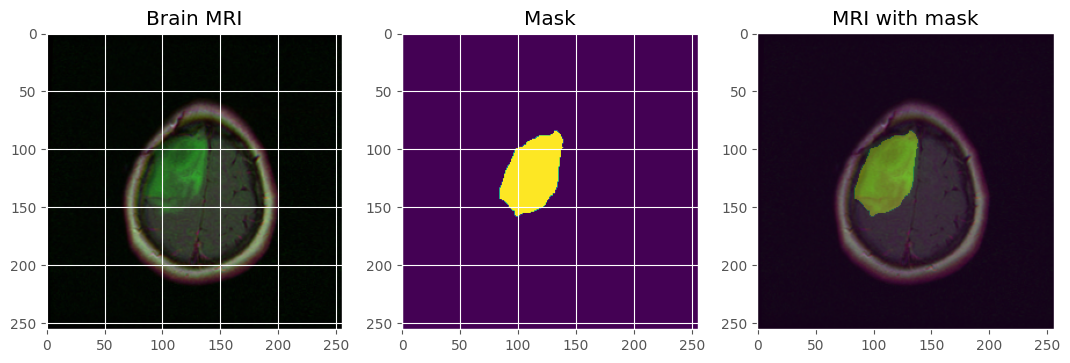

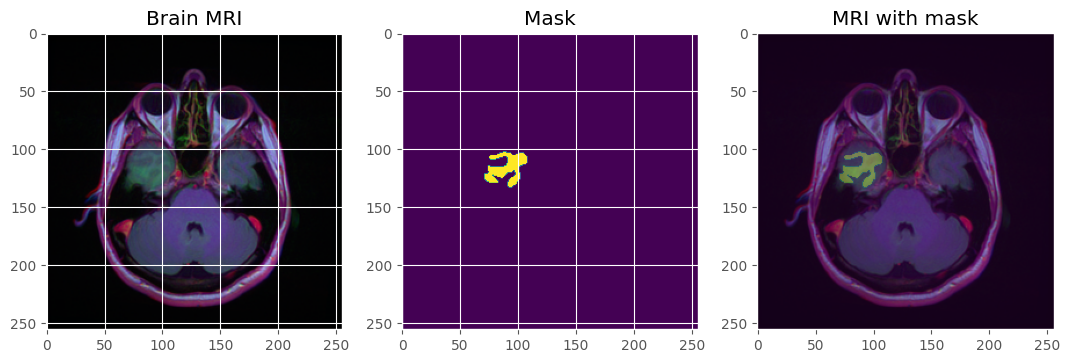

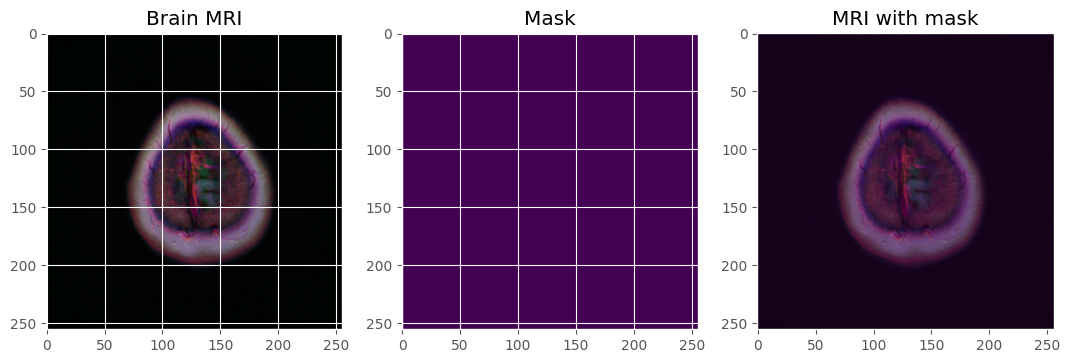

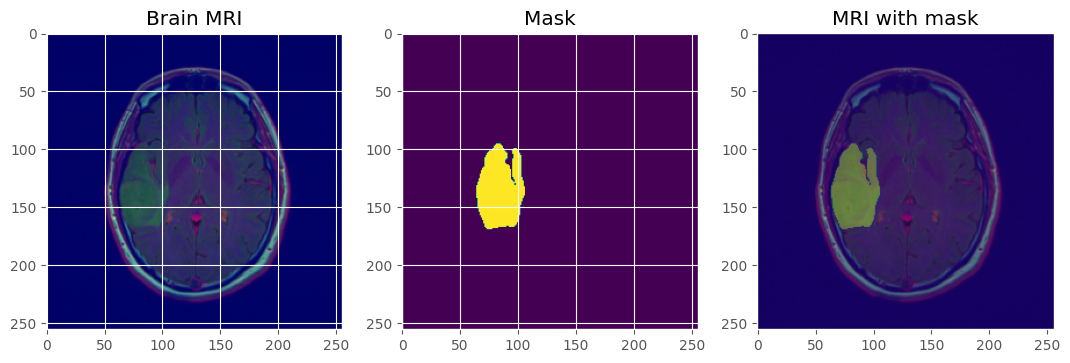

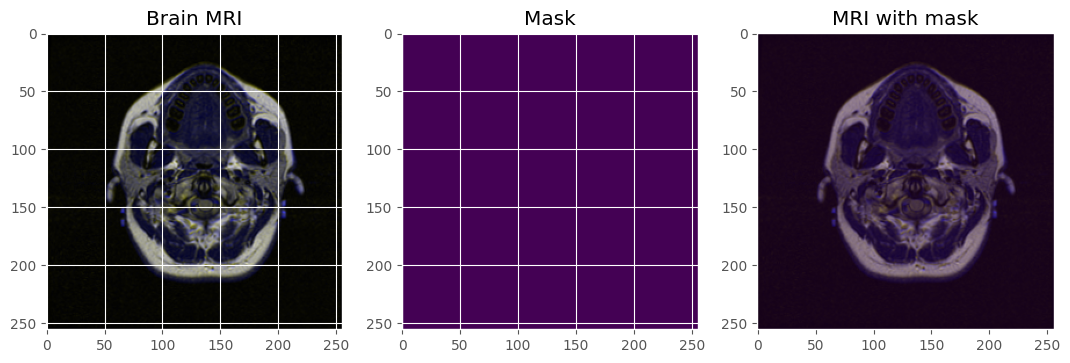

In [26]:
for i in range(5):
    plot_images(imagePath_df)

In [27]:
mask = cv2.imread(imagePath_df['directory'].iloc[10] + '/' + imagePath_df['masks'].iloc[10])

In [28]:
mask[mask == 255] = 1

In [29]:
np.expand_dims(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), -1).shape

(256, 256, 1)

In [30]:
np.expand_dims(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), -1)

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [31]:
for x, y in tf_generator(imagePath_df, 4):
    break

In [32]:
x.shape

(4, 256, 256, 3)

In [33]:
y.shape

(4, 256, 256, 1)

In [34]:
X_train, X_valid, Y_train, Y_valid = train_test_split(imagePath_df.drop(columns=['class']), imagePath_df['class'].to_numpy(),
                                                      test_size=0.15, random_state=42)

In [35]:
train_data = X_train.copy()
train_data['class'] = Y_train

valid_data = X_valid.copy()
valid_data['class'] = Y_valid

In [36]:
train_data

,directory,images,masks,class
152,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_FG_5964_20010511_1.tif,TCGA_FG_5964_20010511_1_mask.tif,0
889,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_HT_A61A_20000127_36.tif,TCGA_HT_A61A_20000127_36_mask.tif,1
1539,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_HT_7686_19950629_8.tif,TCGA_HT_7686_19950629_8_mask.tif,1
1052,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_8163_19961119_9.tif,TCGA_DU_8163_19961119_9_mask.tif,0
102,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_FG_A4MT_20020212_9.tif,TCGA_FG_A4MT_20020212_9_mask.tif,1
...,...,...,...,...
1130,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7013_19860523_24.tif,TCGA_DU_7013_19860523_24_mask.tif,1
1294,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_HT_7879_19981009_9.tif,TCGA_HT_7879_19981009_9_mask.tif,1
860,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_HT_8563_19981209_13.tif,TCGA_HT_8563_19981209_13_mask.tif,1
3507,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_CS_5393_19990606_13.tif,TCGA_CS_5393_19990606_13_mask.tif,0


In [38]:
valid_data

,directory,images,masks,class
1835,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_CS_4942_19970222_2.tif,TCGA_CS_4942_19970222_2_mask.tif,0
1490,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_6400_19830518_42.tif,TCGA_DU_6400_19830518_42_mask.tif,0
2063,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_FG_7637_20000922_13.tif,TCGA_FG_7637_20000922_13_mask.tif,0
1178,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_FG_8189_20030516_47.tif,TCGA_FG_8189_20030516_47_mask.tif,0
3749,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_6408_19860521_7.tif,TCGA_DU_6408_19860521_7_mask.tif,0
...,...,...,...,...
3737,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_6408_19860521_21.tif,TCGA_DU_6408_19860521_21_mask.tif,1
1233,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_CS_5396_20010302_14.tif,TCGA_CS_5396_20010302_14_mask.tif,1
1027,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_FG_7643_20021104_19.tif,TCGA_FG_7643_20021104_19_mask.tif,0
1814,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_6399_19830416_38.tif,TCGA_DU_6399_19830416_38_mask.tif,0


In [59]:
def NUnet():
    activ_F = 'relu'
    activ_out = 'softmax'

    inputs = Input((256, 256, 3))

    conv_1_1 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(inputs)
    conv_1_2 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(conv_1_1)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(pool_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(conv_2_1)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(pool_2)
    conv_3_2 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(conv_3_1)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    conv_4_1 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(pool_3)
    conv_4_2 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(conv_4_1)
    pool_4 = MaxPooling2D(2)(conv_4_2)

    conv_5_1 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(pool_4)
    conv_5_2 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(conv_5_1)
    pool_5 = MaxPooling2D(2)(conv_5_2)


    up_smapling_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
    conc_1 = Concatenate()([conv_5_2, up_smapling_1])
    conv_up_1_1 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(conc_1)
    conv_up_1_2 = Conv2D(512, (3, 3), padding='same', activation=activ_F)(conv_up_1_1)


    up_smapling_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_4_2, up_smapling_2])
    conv_up_2_1 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(conc_2)
    conv_up_2_2 = Conv2D(256, (3, 3), padding='same', activation=activ_F)(conv_up_2_1)


    up_smapling_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_3_2, up_smapling_3])
    conv_up_3_1 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(conc_3)
    conv_up_3_2 = Conv2D(128, (3, 3), padding='same', activation=activ_F)(conv_up_3_1)


    up_smapling_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
    conc_4 = Concatenate()([conv_2_2, up_smapling_4])
    conv_up_4_1 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(conc_4)
    conv_up_4_2 = Conv2D(64, (3, 3), padding='same', activation=activ_F)(conv_up_4_1)


    up_smapling_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
    conc_5 = Concatenate()([conv_1_2, up_smapling_5])
    conv_up_5_1 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(conc_5)
    conv_up_5_2 = Conv2D(32, (3, 3), padding='same', activation=activ_F)(conv_up_5_1)

    result = Conv2D(1, (1, 1), activation='sigmoid')(conv_up_5_2)
    return Model(inputs=inputs, outputs=result)

In [60]:
model = NUnet()
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-5, amsgrad=False), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),iou, dice_coef, precision, sensitivity, specificity,f1_m] )

In [81]:
from keras.callbacks import CSVLogger

callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=False),
    CSVLogger('trainingNew.log', separator=',', append=False)
]

In [82]:
batch_size = 32

history= model.fit(
        tf_generator(train_data, batch_size=batch_size),
        validation_data=tf_generator(valid_data, batch_size=batch_size),
        epochs=150,
        callbacks=[callbacks],
        verbose=1,
        shuffle=True,
        steps_per_epoch=150,
        validation_steps=100
    )

Epoch 1/150
150/150 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9897 - mean_io_u_3: 0.4948 - iou: 0.0358 - dice_coef: 0.0690 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000 - f1_m: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.03766, saving model to model-brain-mri.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 130s 866ms/step - loss: 0.0397 - accuracy: 0.9897 - mean_io_u_3: 0.4948 - iou: 0.0358 - dice_coef: 0.0690 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000 - f1_m: 0.0000e+00 - val_loss: 0.0377 - val_accuracy: 0.9897 - val_mean_io_u_3: 0.4948 - val_iou: 0.0391 - val_dice_coef: 0.0751 - val_precision: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_f1_m: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/150
150/150 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9895 - mean_io_u_3: 0.4948 - iou: 0.0519 - dice_coef: 0.0984 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000 - f1_m: 0.0000e+00
Epoch 2: val_loss improved from 0.03766 to 0.03364, saving model to model-brain-mri.h5
150/150 [==============================] - 127s 849ms/step - loss: 0.0369 - accuracy: 0.9895 - mean_io_u_3: 0.4948 - iou: 0.0519 - dice_coef: 0.0984 - precision: 0.0000e+00 - sensitivity: 0.0000e

In [83]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))


eval_results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

descriptions = ["Loss", "Accuracy", "MeanIOU","IOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity","F1-Score"]

# Combine results list and descriptions list
results_list = zip(eval_results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 7s 639ms/step - loss: 0.0087 - accuracy: 0.9976 - mean_io_u_3: 0.4950 - iou: 0.7375 - dice_coef: 0.8473 - precision: 0.8998 - sensitivity: 0.8472 - specificity: 0.9990 - f1_m: 0.8713

Model evaluation on the test set:
Loss : 0.0087
Accuracy : 0.9976
MeanIOU : 0.495
IOU : 0.7375
Dice coefficient : 0.8473
Precision : 0.8998
Sensitivity : 0.8472
Specificity : 0.999
F1-Score : 0.8713


In [84]:
test_gen = train_generator(df_train, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))


eval_results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

descriptions = ["Loss", "Accuracy", "MeanIOU","IOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity","F1-Score"]

# Combine results list and descriptions list
results_list = zip(eval_results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

Found 2828 validated image filenames.
Found 2828 validated image filenames.
12/12 [==============================] - 3s 221ms/step - loss: 0.0059 - accuracy: 0.9983 - mean_io_u_3: 0.4954 - iou: 0.7787 - dice_coef: 0.8748 - precision: 0.9145 - sensitivity: 0.8874 - specificity: 0.9993 - f1_m: 0.8999

Model evaluation on the test set:
Loss : 0.0059
Accuracy : 0.9983
MeanIOU : 0.4954
IOU : 0.7787
Dice coefficient : 0.8748
Precision : 0.9145
Sensitivity : 0.8874
Specificity : 0.9993
F1-Score : 0.8999


In [87]:
# plt.figure(figsize=(8, 8))
# plt.title("Learning curve")
# plt.plot(history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
# plt.plot(history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
# plt.plot( np.argmin(history["val_loss"]), np.min(history["val_loss"]), marker="x", color="r", label="best model")
# plt.xlabel("Epochs")
# plt.ylabel("log_loss")
# plt.legend()
# # plt.grid(False)
# plt.show()

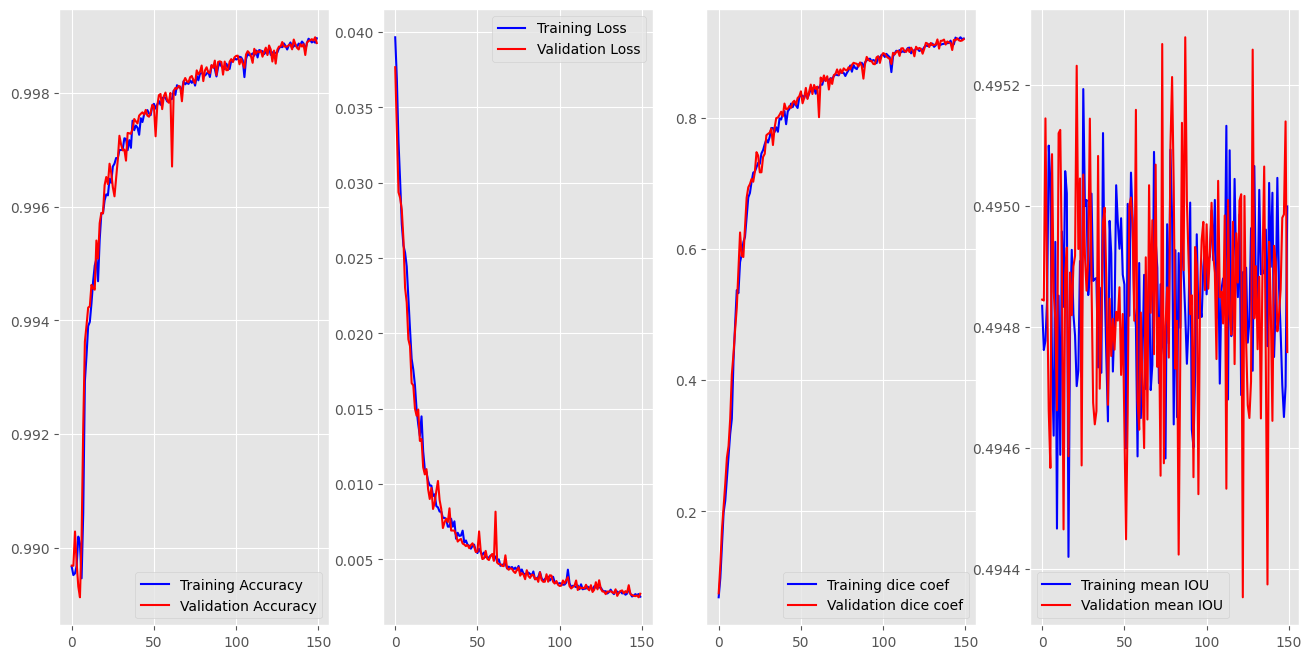

In [88]:
history = pd.read_csv('/kaggle/working/trainingNew.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_3'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_3'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [89]:
for x, y in tf_generator(valid_data, 16):
    break

In [90]:
pred = model.predict(x)

1/1 [==============================] - 0s 33ms/step


In [91]:
data_for_pred_valid_X = []
data_for_pred_valid_Y = []
for elem in tqdm(valid_data.values):
    derictori, image, mask, _ = elem
    
    image = cv2.imread(derictori + '/' + image)
    mask = cv2.imread(derictori + '/' + mask)
    mask[mask == 255] = 1
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    data_for_pred_valid_X += [image]
    data_for_pred_valid_Y += [mask]
data_for_pred_valid_X = np.array(data_for_pred_valid_X) / 255.
data_for_pred_valid_Y = np.expand_dims(np.array(data_for_pred_valid_Y), -1)
predict_data = []
for elem in model.predict(data_for_pred_valid_X):
    elem[elem > 0.5] = 1
    predict_data.append(elem)
predict_data = np.array(predict_data)

100%|██████████| 590/590 [00:01<00:00, 416.21it/s]


19/19 [==============================] - 4s 205ms/step


In [92]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_true=data_for_pred_valid_Y, y_pred=predict_data)
print(f'MeanIoU = {m.result().numpy()}')

MeanIoU = 0.9423876404762268


In [93]:
m = tf.keras.metrics.IoU(target_class_ids=[0, 1], num_classes=2)
m.update_state(y_true=data_for_pred_valid_Y, y_pred=predict_data)
print(f'IoU = {m.result().numpy()}')

IoU = 0.9423876404762268


In [78]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Example ground truth and predicted labels
# y_true = [1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
# y_pred = [1, 0, 0, 1, 0, 1, 1, 0, 1, 0]

# # Create confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Visualize confusion matrix using seaborn
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()